**Setting up the network**

In [16]:
import pandas as pd

import os

import pypsa

In [17]:


# Specify the path to the directory you want to set as the working directory
new_directory = '/Users/danialriaz/PyPSA-Eur'

# Change the current working directory to the new directory
os.chdir(new_directory)

n = pypsa.Network("results/test-elec/networks/with wind/elec_s_8_ec_lcopt_Co2L-1H-10.nc")


INFO:pypsa.io:Imported network elec_s_8_ec_lcopt_Co2L-1H-10.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


(<matplotlib.collections.PatchCollection at 0x16c3b25d0>,
 <matplotlib.collections.LineCollection at 0x16c3a4590>)

/Users/danialriaz/miniforge3/envs/pypsa-eur/lib/python3.11/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


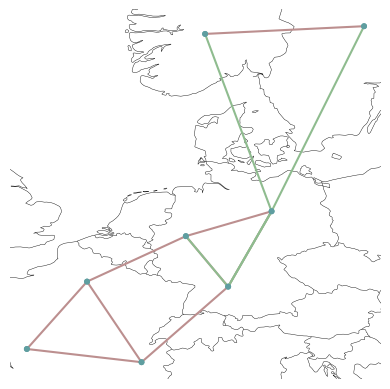

In [22]:
n.plot()

# Wide form mapping #

In [23]:
## GENERATORS ##

# Convert n.generators_t.p into a DataFrame
generators_df = n.generators_t.p.reset_index()

# Rename the 'index' column to 'timestamp'
generators_df.rename(columns={'snapshot': 'timestamp'}, inplace=True)

# Melt the DataFrame
generators_df_long = pd.melt(generators_df, id_vars=['timestamp'], var_name='bus_tech', value_name='generation')

# # Split the values in the 'technology' column
generators_df_long[['country', 'bus', 'technology']] = generators_df_long['bus_tech'].str.split(' ', expand=True)

# # Drop the original 'technology' column
generators_df_long.drop(columns=['bus_tech'], inplace=True)

# # Assuming df is your DataFrame
generators_df_long['country'] = generators_df_long['country'].str[:-1]

# Replace 'technology' values containing 'wind' with 'wind'
generators_df_long.loc[generators_df_long['technology'].str.contains('wind'), 'technology'] = 'wind'


## STORAGE ##

# Convert n.storage_units_t.p into a DataFrame
hydro_gen_df = n.storage_units_t.p_dispatch.reset_index()

# Rename the 'index' column to 'timestamp'
hydro_gen_df.rename(columns={'snapshot': 'timestamp'}, inplace=True)

# Melt the DataFrame
hydro_gen_df_long = pd.melt(hydro_gen_df, id_vars=['timestamp'], var_name='bus_tech', value_name='generation')

# # Split the values in the 'technology' column
hydro_gen_df_long[['country', 'bus', 'technology']] = hydro_gen_df_long['bus_tech'].str.split(' ', expand=True)

# # Drop the original 'technology' column
hydro_gen_df_long.drop(columns=['bus_tech'], inplace=True)

# # Assuming df is your DataFrame
hydro_gen_df_long['country'] = hydro_gen_df_long['country'].str[:-1]

hydro_gen_df_long['technology'] = hydro_gen_df_long['technology'].replace({'hydro': 'reservoir'})


## MERGE ##

generation_df = pd.merge(generators_df_long, hydro_gen_df_long, on=['country','timestamp', 'bus','technology', 'generation'], how='outer')

## WIDE FORM ##

generation_df.head(10)

wide_gen = generation_df.groupby(['country','timestamp' ,'technology'])['generation'].sum().reset_index()
wide_gen['generation']/=1000
wide_gen.rename(columns={'generation': 'generation (GWh)'}, inplace=True)
wide_gen = wide_gen.round(0)

wide_gen_df = wide_gen.pivot_table(index=['country','timestamp'], columns='technology', values='generation (GWh)', aggfunc='sum').reset_index()

desired_order = ['country', 'timestamp', 'ror', 'reservoir', 'PHS', 'solar', 'wind', 'nuclear', 'CCGT', 'lignite', 'OCGT', 'coal']
wide_gen_df = wide_gen_df[desired_order]
wide_gen_df['total_gen (GWh)'] = wide_gen_df[['ror', 'reservoir', 'PHS', 'solar', 'wind', 'nuclear', 'CCGT', 'lignite', 'OCGT', 'coal']].sum(axis=1)


In [ ]:
# Transform n.buses_t.marginal_price into a DataFrame
loads_df = pd.DataFrame(n.loads_t.p_set)

loads_df.reset_index(inplace=True)

# Rename the 'index' column to 'timestamp'
loads_df.rename(columns={'snapshot': 'timestamp'}, inplace=True)

# Melt the DataFrame
loads_long = pd.melt(loads_df, id_vars=['timestamp'], var_name='country_bus', value_name='load')

# Split the values in the 'technology' column
loads_long[['country', 'bus']] = loads_long['country_bus'].str.split(' ', expand=True)

# Drop the original 'technology' column
loads_long.drop(columns=['country_bus'], inplace=True)

# Edit country names
loads_long['country'] = loads_long['country'].str[:-1]

loads_grouped = loads_long.groupby(['country', 'timestamp'])['load'].sum().reset_index()
loads_grouped['load'] *= (1/1000)  # Convert MWh to GWh
loads_grouped.rename(columns={'load': 'load (GWh)'}, inplace=True)  # Rename the column to indicate GWh
loads_grouped['load (GWh)'] = loads_grouped['load (GWh)']
loads_grouped = loads_grouped.round(2)

## MERGE ##

# load_gen_df = pd.merge(wide_gen_df, loads_grouped, on=['country','timestamp'], how='outer')
# load_gen_df[load_gen_df['country'] == 'DE'].sort_values(by= ['solar'], ascending=False).head(30)

In [61]:
n.statistics.capacity_factor()

component    carrier             
Line         AC                      0.245900
Link         DC                      0.834590
StorageUnit  Pumped Hydro Storage    0.258832
             Reservoir & Dam         0.472512
Generator    Combined-Cycle Gas      0.222818
             Offshore Wind (AC)      0.476817
             Offshore Wind (DC)      0.585229
             Onshore Wind            0.241377
             Open-Cycle Gas          0.027609
             Run of River            0.580334
             Solar                   0.120545
             coal                    0.147999
             lignite                 0.893205
             nuclear                 0.710974
Load         -                            NaN
dtype: float64

Line 2: DE -> FR
Line 4: DE -> FR
Line 8: NO -> SE

In [25]:
n.lines

,bus0,bus1,v_nom,num_parallel,length,carrier,type,s_max_pu,s_nom,capital_cost,...,build_year,lifetime,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu
Line,,,,,,,,,,,,,,,,,,,,,
0,DE0 0,DE0 1,380.0,10.000000,533.154523,AC,Al/St 240/40 4-bundle 380.0,0.7,16981.026117,22452.253977,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
1,DE0 0,DE0 2,380.0,19.736842,381.008306,AC,Al/St 240/40 4-bundle 380.0,0.7,33515.183126,16040.714510,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
2,DE0 0,FR0 1,380.0,3.289474,636.755782,AC,Al/St 240/40 4-bundle 380.0,0.7,5585.863854,26813.459734,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
3,DE0 1,DE0 2,380.0,7.157895,388.234497,AC,Al/St 240/40 4-bundle 380.0,0.7,12154.839747,16350.414684,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
4,DE0 2,FR0 0,380.0,2.289474,517.217256,AC,Al/St 240/40 4-bundle 380.0,0.7,3887.761243,21783.713715,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
5,FR0 0,FR0 1,380.0,12.447368,589.335451,AC,Al/St 240/40 4-bundle 380.0,0.7,21136.908825,24810.469097,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
6,FR0 0,FR0 2,380.0,12.157895,522.952803,AC,Al/St 240/40 4-bundle 380.0,0.7,20645.352806,22019.471981,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
7,FR0 1,FR0 2,380.0,5.447368,540.098974,AC,Al/St 240/40 4-bundle 380.0,0.7,9250.190543,22739.011807,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0
8,NO1 0,SE1 0,380.0,4.289474,511.577024,AC,Al/St 240/40 4-bundle 380.0,0.7,7283.966466,21540.710998,...,0,inf,1.0,-inf,inf,,0.0,0.0,0.0,0.0


In [26]:
# Line losses
(n.lines_t.p1 + n.lines_t.p0).sum()

Line
0    634193.218835
1      5721.233468
2        41.827364
3     95283.515117
4        12.144953
5        17.379564
6       223.401473
7        17.672042
8      7258.894874
dtype: float64

In [27]:
n.lines_t.p1.sum()

Line
0    4.403627e+07
1    5.311437e+07
2    2.170128e+07
3   -2.402414e+07
4    1.724476e+07
5   -1.521286e+07
6   -3.089807e+07
7   -6.139921e+06
8   -4.521101e+06
dtype: float64

sum lines 2 & 4 for DE -> FR

line 8 for NO --> SE

finally add a coloumn for the summed line losses

<Axes: xlabel='snapshot'>

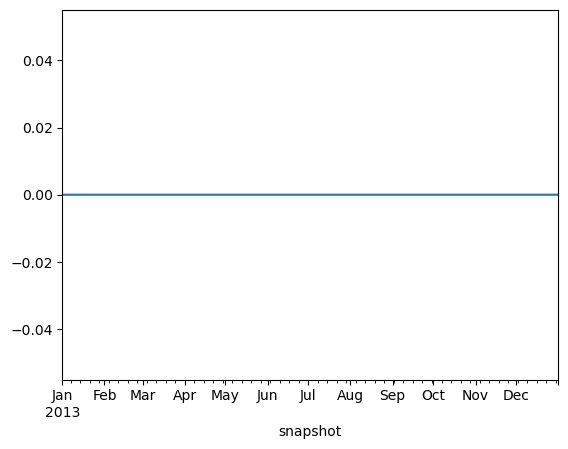

DC links have 0 losses but they do transfer electricity

14848: DE --> NO

T16+1: DE --> SE

In [29]:
n.links

,bus0,bus1,carrier,geometry,length,tags,under_construction,underground,p_min_pu,underwater_fraction,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down
Link,,,,,,,,,,,,,,,,,,,,,
14848,DE0 1,NO1 0,DC,"LINESTRING(6.81690675921544 58.6338502746805,6...",1203.181813,,1.0,0.0,-1.0,0.208083,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
T10,DE0 1,DE0 0,DC,"LINESTRING (11.629014 52.252137, 12.091596 48....",533.154523,"""name""=>""HVDC SuedOstLink"", ""ref""=>""https://ty...",1.0,0.0,-1.0,0.000000,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
T18,DE0 1,DE0 0,DC,"LINESTRING (9.373979 53.922479, 9.117193 49.14...",533.154523,"""name""=>""HVDC SuedLink"", ""ref""=>""https://tyndp...",1.0,0.0,-1.0,0.013814,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
T20,DE0 2,DE0 0,DC,"LINESTRING (6.619451 51.272935, 8.458036 49.23...",381.008306,"""name""=>""HVDC Ultranet"", ""ref""=>""https://tyndp...",1.0,0.0,-1.0,0.000000,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0
T16+1,DE0 1,SE1 0,DC,,1274.350070,,0.0,0.0,-1.0,0.076428,...,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0


In [30]:
# Evaluate losses by adding in Link names
(n.links_t.p0.filter(like='T16+1').sum(axis = 1) + n.links_t.p1.filter(like='T16+1').sum(axis = 1)).sum()

0.0

In [70]:
# DE --> SE
# -ve implies that Sweden is taking this amount from Germany

a = (n.links_t.p0.filter(like='T16+1').sum(axis = 1).sum() / (1e6)).round(1)

print("Norway is taking", -a, "TWh of energy from Germany")

Norway is taking 27.4 TWh of energy from Germany


In [73]:
(27/131)*100

20.610687022900763

In [69]:
# DE --> NO
# -ve implies that Norway is taking this amount from Germany

b = ((n.links_t.p0.filter(like='14848').sum(axis = 1).sum()) / (1e6)).round(1)

print("Norway is taking", -b, "TWh of energy from Germany")

Norway is taking 1.7 TWh of energy from Germany


In [ ]:
demand = n.loads_t.p.sum(axis=1) + (n.lines_t.p1 + n.lines_t.p0).sum(axis = 1) # + n.links_t.p0.filter(like='Electrolysis').sum(axis = 1)
                                    
supply = n.generators_t.p.sum(axis=1) + n.storage_units_t.p.sum(axis=1) # + n.stores_t.p.sum(axis=1) + n.links_t.p1.filter(like='H2 Fuel Cell').sum(axis = 1)

(demand-supply).round(1).plot()